In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import pyplot
from math import sqrt
import datetime

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

from statsmodels.tsa.arima.model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('municipality_bus_utilization.csv')

### Exploratory Data Analysis

In [3]:
df.shape

(13070, 4)

In [4]:
df.head()

,timestamp,municipality_id,usage,total_capacity
0,2017-06-04 07:59:42,9,454,1332
1,2017-06-04 07:59:42,8,556,2947
2,2017-06-04 07:59:42,4,1090,3893
3,2017-06-04 07:59:42,0,204,2813
4,2017-06-04 07:59:42,7,718,2019


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13070 entries, 0 to 13069
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   timestamp        13070 non-null  object
 1   municipality_id  13070 non-null  int64 
 2   usage            13070 non-null  int64 
 3   total_capacity   13070 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 408.6+ KB


In [6]:
df.isnull().sum()

timestamp          0
municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [7]:
df.describe()

,municipality_id,usage,total_capacity
count,13070.000000,13070.000000,13070.000000
mean,4.500000,876.002984,1972.800000
std,2.872391,679.287109,1144.074782
min,0.000000,11.000000,397.000000
25%,2.000000,403.000000,697.000000
50%,4.500000,692.000000,1974.500000
75%,7.000000,1190.000000,2947.000000
max,9.000000,3508.000000,3893.000000


In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp'], infer_datetime_format=True)
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour

In [9]:
df = df.groupby(['municipality_id','date','hour'])[["usage"]].max().reset_index()

In [10]:
df = df.set_index('date').sort_index()

In [11]:
train, test = df[0:5320], df[5320:]
print('Train: %d, Test: %d' % (len(train), len(test)))

Train: 5320, Test: 1420


In [12]:
train_dict = {}
for idx in range(train['municipality_id'].nunique()):
    df = train.loc[train['municipality_id'] == idx]
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)
    train_dict[f'df{idx}'] = df

In [13]:
test_dict = {}
for idx in range(test['municipality_id'].nunique()):
    df = test.loc[test['municipality_id'] == idx]
    df.index = pd.to_datetime(df.index, infer_datetime_format=True)
    test_dict[f'df{idx}'] = df

MUNICIPALITY [0]


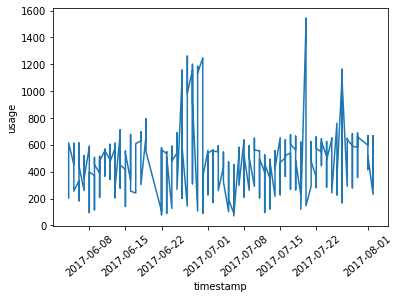

MUNICIPALITY [1]


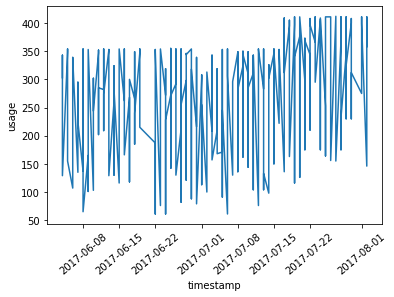

MUNICIPALITY [2]


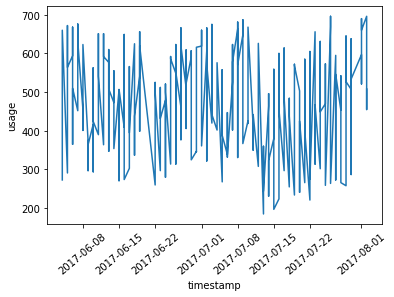

MUNICIPALITY [3]


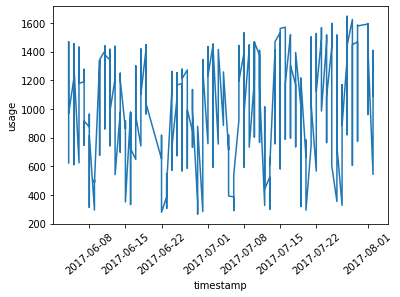

MUNICIPALITY [4]


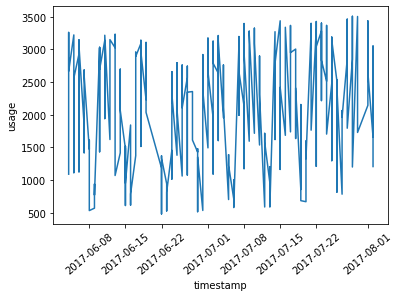

MUNICIPALITY [5]


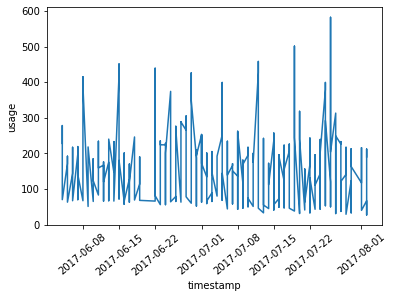

MUNICIPALITY [6]


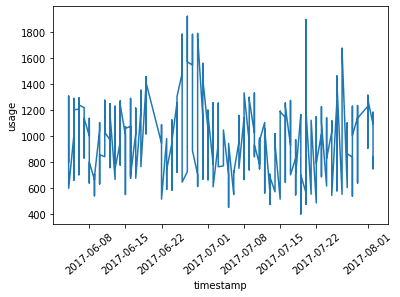

MUNICIPALITY [7]


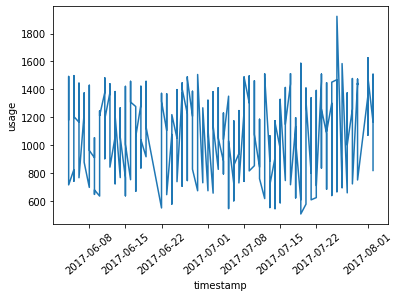

MUNICIPALITY [8]


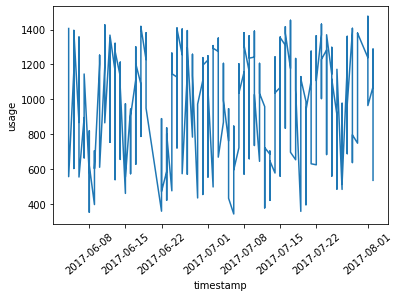

MUNICIPALITY [9]


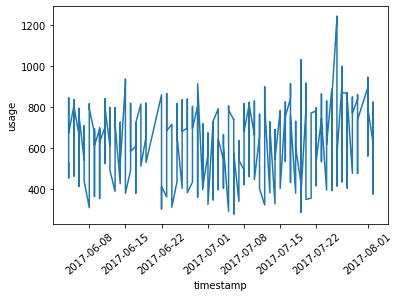

In [14]:
for i in train_dict.keys(): 
    train_df = train_dict[i]
    print('MUNICIPALITY {}'.format(train_dict[i]['municipality_id'].unique()))
    plt.ylabel('usage')
    plt.xlabel('timestamp')
    plt.xticks(rotation = 40)
    plt.plot(train_df.index, train_df['usage'])
    plt.show()

###### Decomposition

MUNICIPALITY [0]


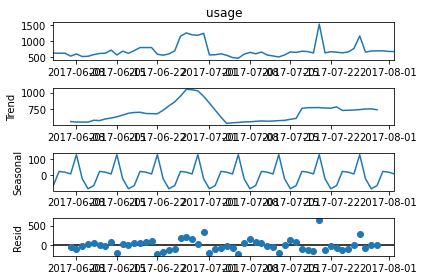

MUNICIPALITY [1]


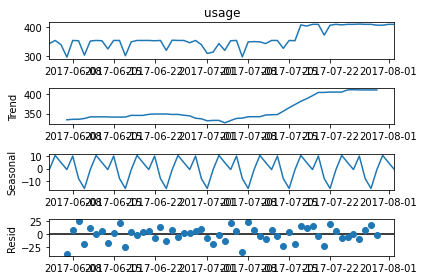

MUNICIPALITY [2]


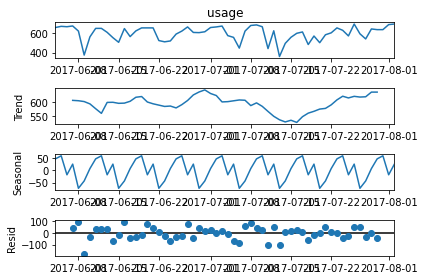

MUNICIPALITY [3]


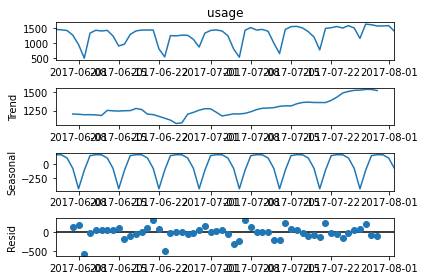

MUNICIPALITY [4]


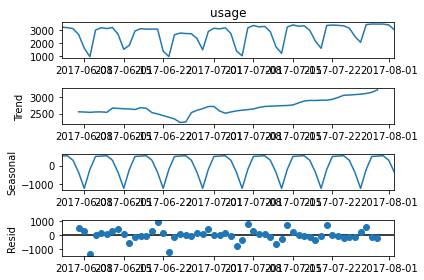

MUNICIPALITY [5]


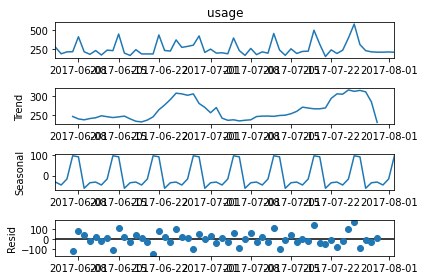

MUNICIPALITY [6]


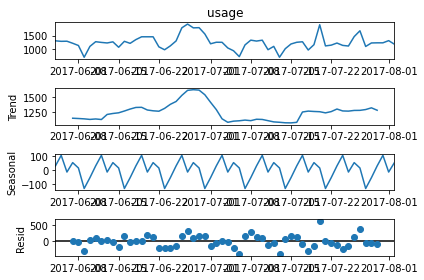

MUNICIPALITY [7]


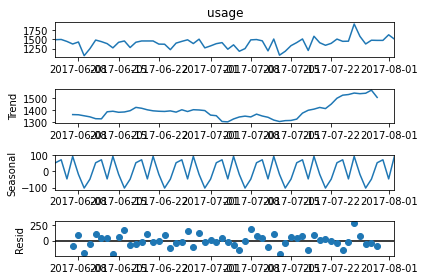

MUNICIPALITY [8]


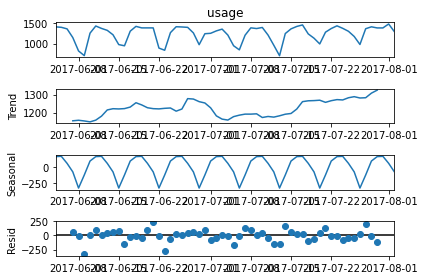

MUNICIPALITY [9]


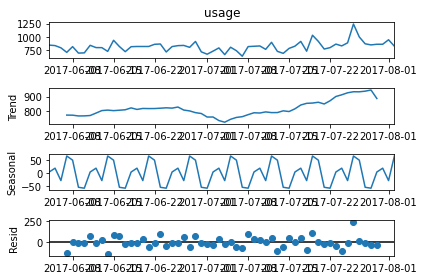

In [15]:
for key, value in train_dict.items():
    print('MUNICIPALITY {}'.format(train_dict[key]['municipality_id'].unique()))    
    
    value.index = pd.to_datetime(value.index)
    value = value.resample('D').max()
    value = value.fillna(method='ffill')
    result = seasonal_decompose(value['usage'], model='additive')
    result.plot()
    plt.show()

###### Autocorrelation

<Figure size 432x288 with 0 Axes>

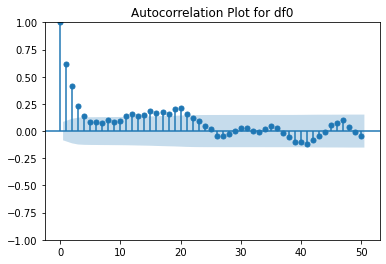

<Figure size 432x288 with 0 Axes>

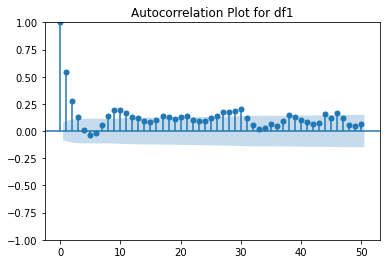

<Figure size 432x288 with 0 Axes>

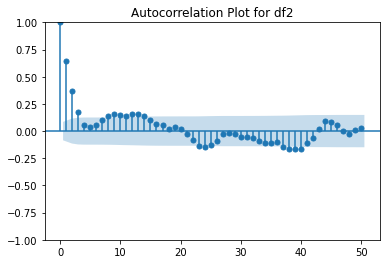

<Figure size 432x288 with 0 Axes>

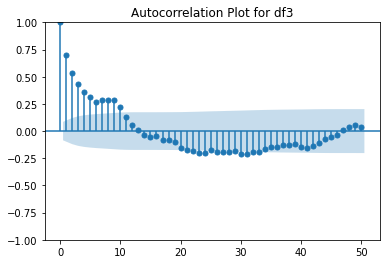

<Figure size 432x288 with 0 Axes>

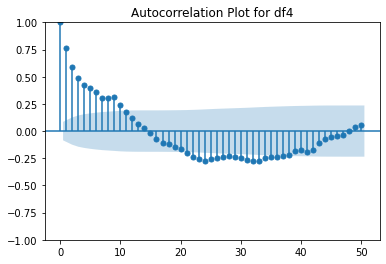

<Figure size 432x288 with 0 Axes>

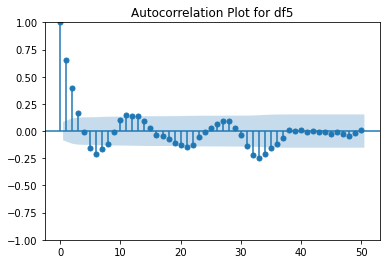

<Figure size 432x288 with 0 Axes>

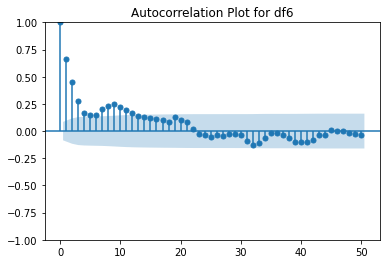

<Figure size 432x288 with 0 Axes>

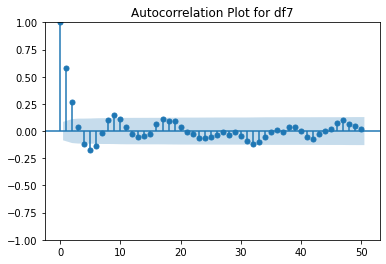

<Figure size 432x288 with 0 Axes>

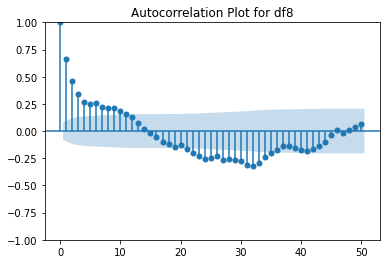

<Figure size 432x288 with 0 Axes>

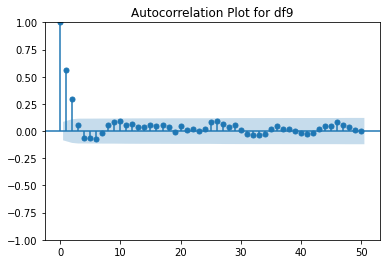

In [16]:
for key in train_dict.keys():
    plt.figure()
    plot_acf(train_dict[key]['usage'], lags=50)
    plt.title(f"Autocorrelation Plot for {key}")
    plt.show()

###### Stationarity

In [17]:
from statsmodels.tsa.stattools import adfuller
for key in train_dict.keys():
    adf, pval, usedlag, nobs, crit_vals, icbest =  adfuller(train_dict[key]['usage'].values)
    print('\nunit root test on {}'.format(key))
    print('\nADF test statistic:', adf)
    print('ADF p-values:', pval)
    print('ADF number of lags used:', usedlag)
    print('ADF number of observations:', nobs)
    print('ADF critical values:', crit_vals)
    print('ADF best information criterion:', icbest)
    if (pval < 0.05) and (adf < crit_vals['5%']):
        print('\nThe series is stationary')
    else:
        print('\nThe series is NOT stationary')
    


unit root test on df0

ADF test statistic: -9.38989375964188
ADF p-values: 6.604336784397814e-16
ADF number of lags used: 2
ADF number of observations: 529
ADF critical values: {'1%': -3.442772146350605, '5%': -2.8670191055991836, '10%': -2.5696881663873414}
ADF best information criterion: 6755.513479944595

The series is stationary

unit root test on df1

ADF test statistic: -12.420227685587975
ADF p-values: 4.15290423381308e-23
ADF number of lags used: 0
ADF number of observations: 531
ADF critical values: {'1%': -3.4427251295084678, '5%': -2.8669984098683736, '10%': -2.5696771375119254}
ADF best information criterion: 5856.545936944824

The series is stationary

unit root test on df2

ADF test statistic: -10.532220244800998
ADF p-values: 9.089753326383399e-19
ADF number of lags used: 1
ADF number of observations: 530
ADF critical values: {'1%': -3.4427485933555886, '5%': -2.8670087381529723, '10%': -2.569682641509434}
ADF best information criterion: 6079.750425719729

The series is

### Model Building

##### Moving Average (MA) Model


MUNICIPALITY 0


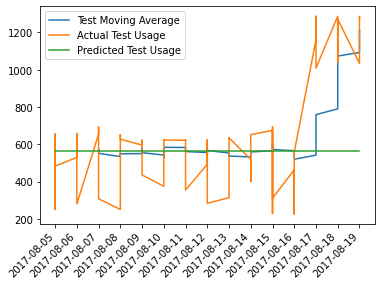

MAE:  203.28462441314554
MSE:  97262.30161874022
RMSE:  311.86904562450604

MUNICIPALITY 1


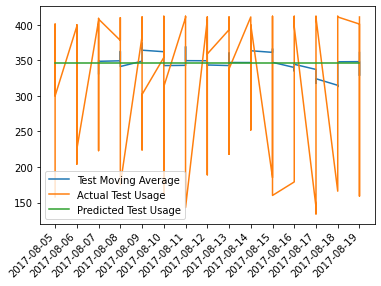

MAE:  69.35093896713613
MSE:  6816.718212050078
RMSE:  82.5634193335649

MUNICIPALITY 2


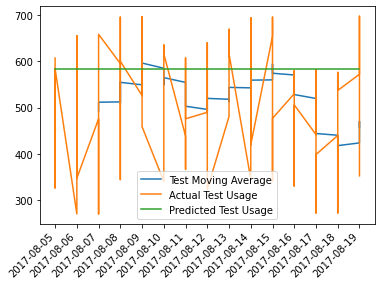

MAE:  103.17840375586856
MSE:  18094.909013106422
RMSE:  134.51731863632438

MUNICIPALITY 3


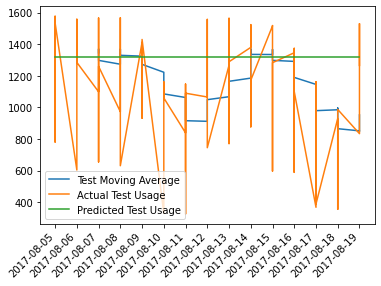

MAE:  293.35328638497657
MSE:  148551.15842625193
RMSE:  385.423349612153

MUNICIPALITY 4


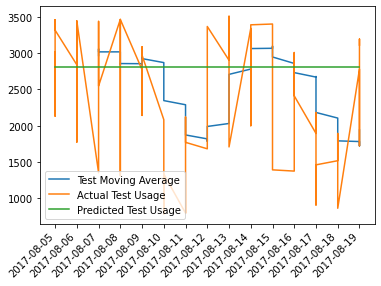

MAE:  674.8356807511736
MSE:  710753.6287167451
RMSE:  843.0620550806121

MUNICIPALITY 5


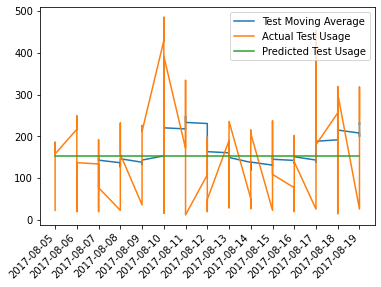

MAE:  83.58333333333333
MSE:  11929.53041862285
RMSE:  109.22238973133142

MUNICIPALITY 6


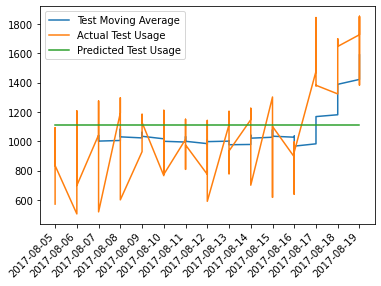

MAE:  227.95598591549296
MSE:  90345.40823063381
RMSE:  300.57512909526264

MUNICIPALITY 7


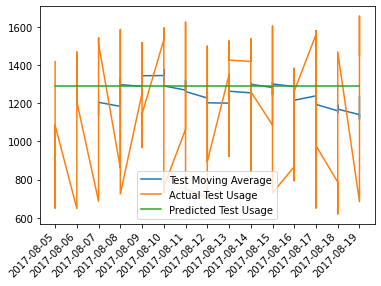

MAE:  231.78638497652585
MSE:  83918.62145442097
RMSE:  289.687109575868

MUNICIPALITY 8


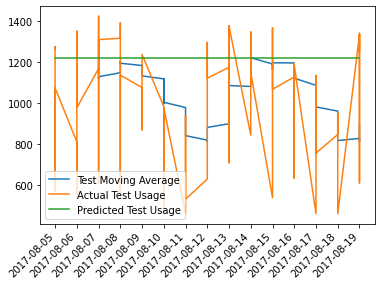

MAE:  239.2288732394366
MSE:  104637.22095070423
RMSE:  323.4767703417113

MUNICIPALITY 9


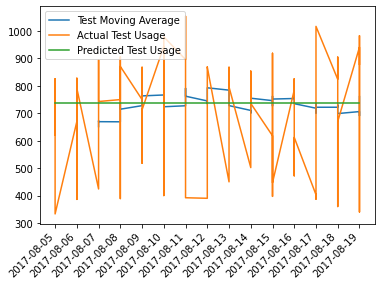

MAE:  147.12089201877933
MSE:  32242.836756651013
RMSE:  179.56290473438833


In [18]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error

def moving_average(data, window_size):
    
    return data.rolling(window_size).mean()

def predict_and_plot(train, test, window_size):
    
    train_ma = moving_average(train['usage'], window_size)
    test_ma = moving_average(test['usage'], window_size)

    # Use the last value of the moving average of the train data to predict the test data
    preds = np.ones(len(test)) * train_ma.iloc[-1]
    
    plt.plot(test.index, test_ma, label='Test Moving Average')
    plt.plot(test.index, test['usage'], label='Actual Test Usage')
    plt.plot(test.index, preds, label='Predicted Test Usage')
    plt.xticks(rotation=45, ha='right')
    plt.legend()
    
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator())
    
    plt.show()
    
    mae = mean_absolute_error(test['usage'], preds)
    mse = mean_squared_error(test['usage'], preds)
    rmse = sqrt(mse)
    
    print("MAE: ", mae)
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    
    return preds

train_dict = {}
test_dict = {}

for idx in range(train['municipality_id'].nunique()):
    train_dict[f'df{idx}'] = train.loc[train['municipality_id'] == idx]
    test_dict[f'df{idx}'] = test.loc[test['municipality_id'] == idx]

window_size = 24  # Number of hours in a day

for key, train_data in train_dict.items():
    test_data = test_dict[key]
    print('\nMUNICIPALITY {}'.format(train_data['municipality_id'].iloc[0]))
    preds = predict_and_plot(train_data, test_data, window_size)


###### ARIMA Model

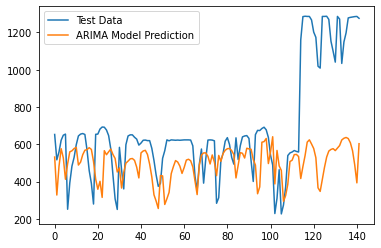

MAE:  228.37583962717292
MSE:  108649.13400255587
RMSE:  329.6196808483314


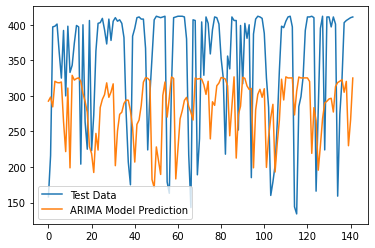

MAE:  99.9179439361154
MSE:  12526.62156285248
RMSE:  111.92239080207536


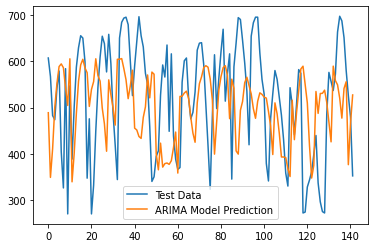

MAE:  108.65217632381112
MSE:  18529.57157423165
RMSE:  136.12336894975692


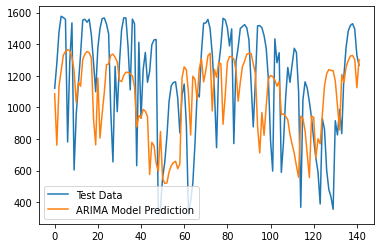

MAE:  317.8305085056551
MSE:  145992.29903385442
RMSE:  382.08938618319985


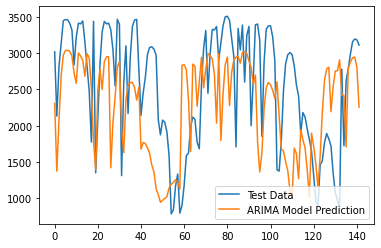

MAE:  721.542481240676
MSE:  759720.858336641
RMSE:  871.6196752808194


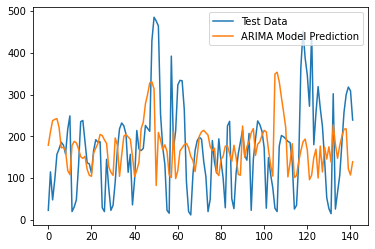

MAE:  91.89442955770672
MSE:  14329.459268236214
RMSE:  119.70571944663385


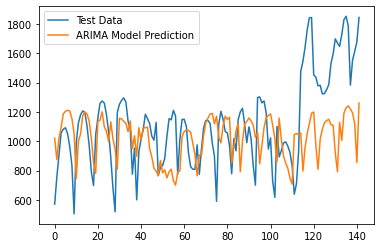

MAE:  242.12117605337144
MSE:  99095.0361286869
RMSE:  314.7936405467666


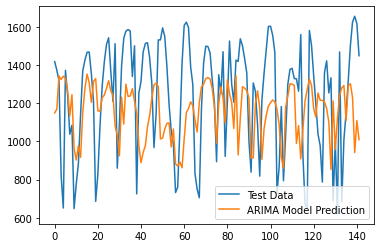

MAE:  254.87086175728237
MSE:  94351.58138279984
RMSE:  307.1670252204814


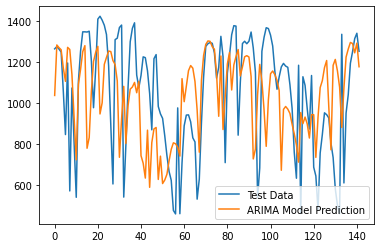

MAE:  232.01700344101374
MSE:  85556.83108077274
RMSE:  292.50099329877963


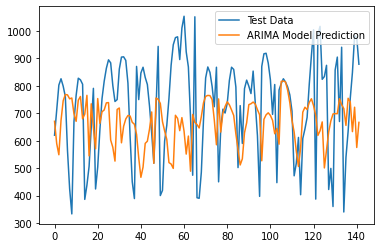

MAE:  172.30285112621667
MSE:  43127.81671465363
RMSE:  207.67237831414565


In [19]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

def predict_and_plot(train, test, order):
    model = ARIMA(train, order=order)
    model = model.fit()
    train_new = train.reset_index()
    test_new = test.reset_index()
    preds = model.predict(start=test_new.index[0], end=test_new.index[-1], typ='levels')
   
    plt.plot(np.array(test_new.index), np.array(test_new['usage']), label='Test Data')
    plt.plot(np.array(test_new.index), np.array(preds), label='ARIMA Model Prediction')
    plt.legend(loc='best')
    plt.show()
    
    mae = mean_absolute_error(test_new['usage'], preds)
    mse = mean_squared_error(test_new['usage'], preds)
    rmse = sqrt(mse)
    
    print("MAE: ", mae)
    print("MSE: ", mse)
    print("RMSE: ", rmse)
    
    return preds

train_dict = {}
test_dict = {}

for idx in range(train['municipality_id'].nunique()):
    train_dict[f'df{idx}'] = train.loc[train['municipality_id'] == idx]['usage']
    test_dict[f'df{idx}'] = test.loc[test['municipality_id'] == idx]['usage']

order = (1,0,1)  # (p,d,q)

for key, train_data in train_dict.items():
    test_data = test_dict[key]
    preds = predict_and_plot(train_data, test_data, order)
